# Install dependencies locally

If you are running this notebook locally (i.e., not through Colaboratory), you will also need to install a few more dependencies. Run the following on the command line to install the graph networks library, as well as a few other dependencies:

```
pip install graph_nets matplotlib scipy "tensorflow>=1.15,<2" "dm-sonnet<2" "tensorflow_probability<0.9"

In [1]:
install_graph_nets_library = "No"  #@param ["Yes", "No"]

if install_graph_nets_library.lower() == "yes":
  print("Installing Graph Nets library and dependencies:")
  print("Output message from command:\n")
  !pip install graph_nets "dm-sonnet<2" "tensorflow_probability<0.9"
else:
  print("Skipping installation of Graph Nets library")

Skipping installation of Graph Nets library


# load libraries

In [1]:
import configparser
confParser = configparser.ConfigParser()
confParser.read('config.ini')
confParser.sections()


['gnn library path', 'python libarary path', 'test data files']

In [2]:
import sys
sys.path.append(confParser['gnn library path']['gnnLibDir'])
sys.path.append(confParser['python libarary path']['pyLibDir'])
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pdb
import utility as utl
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
import os
import traceback
import imp
imp.reload(utl)
from scipy.spatial import KDTree
from scipy.interpolate import Rbf

import functools
from typing import Any, Dict, Text,Tuple,Optional


import enum
import pickle
#from absl import logging
import numpy as np


import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp

import sonnet as snt

from graph_nets import graphs
from graph_nets import modules as gn_modules
from graph_nets import utils_tf
from gnn_graphnet_model import *
from graph_nets import utils_np

from sklearn.preprocessing import StandardScaler
from scipy import stats


# utility funcs

In [3]:
class AddMissing:
    '''
    interpolate using k-nearest neighbors
    '''
    def __init__(self,cords,val,query_index):

        self.query_index = query_index.flatten()
        self.points    = cords
        self.val = val.copy()

    def kdTree(self,k):
        tree = KDTree( self.points )
        dd, ii = tree.query([self.points], k=k)
        self.neigh_mat= ii[0] #--- nearest neighbor matrix
        
    def interpolate(self):
        #--- nearest neighbor values
        h_mat = np.c_[list(map(lambda x:self.val[x].flatten(),self.neigh_mat))]
        assert np.all(list(map(lambda x:np.any(x>0.0),h_mat))), 'increase k!'
        #--- filter query points
        h_list = list(map(lambda x:x[x>0.0],h_mat[self.query_index]))
        assert len(h_list) == h_mat[self.query_index].shape[0]
        
        #--- average
        h_mean = list(map(lambda x: x.mean(), h_list))
        query_rows = np.arange(self.query_index.shape[0])[self.query_index]
        self.val[query_rows] = np.c_[h_mean]

        
        
def load_test_data(test_data_file_path,test_data_file_path2nd):
    # read the csv file and return the text line list.
    test_data_row_list = pd.read_csv(test_data_file_path,sep=',')
    test_data_row_list2nd = pd.read_csv(test_data_file_path2nd,sep=',')
    print('open and load data from test_data.csv complete.')
    return test_data_row_list, test_data_row_list2nd

def train_test_split(x,y):
    xlo, xhi = x.min(), x.max()
    ylo, yhi = y.min(), y.max()
    x_copy = np.array(x.copy() - xlo)
    y_copy = np.array(y.copy() - ylo)
    
    return x_copy < 0.7 * (xhi-xlo)

    
def base_graph( 
               test_data_file_path, 
               test_data_file_path2nd,
               predictors,
                train_mask,
                test_mask,
               logtrans=False
              ):
    """
    This here loads the data and forms a graph structure. This should be implemented as it is dataset-dependent.
    Output should be:
        a dict with  globals (dummy), nodes (nodal data in numpy), edges (edge data), receivers (indices of receiving node in int), senders (int)
        train_mask   array of size (n_nodes) with bool or 0/1 indicating training nodes
        val_mask     same for validation nodes 
        test_mask    same for testing nodes
        target 	     here the array containing the nodal target data
        weight	     if needed, a weight parameter given for the (training) nodes
    """
    
    test_data, test_data2nd = load_test_data(test_data_file_path, 
                                             test_data_file_path2nd
                                            )
    #--- do interpolation for missing attributes
#     interp = AddMissing(np.c_[test_data[['x','y']]],
#                          np.c_[test_data['h(Gpa)']],
#                          np.c_[test_data['h(Gpa)']==0.0],
#                                )

#     interp.kdTree(64) #--- nearest neighbors
#     interp.interpolate()

#     #--- update data frame
#     cols = list(test_data.keys())
#     cols.remove('h(Gpa)')
#     test_data = pd.DataFrame(np.c_[test_data[cols],interp.val.flatten()],columns=cols+['h(Gpa)'])

    
    #--- assignment
    positions = np.c_[test_data[['x','y','perimeter','boundarySize','numNeighbors']]].tolist() 
    edges = list(map(lambda x:[x],np.array(test_data2nd['misOrientationAngle(deg)'])))
    receivers = list(test_data2nd['grain_j_index'].astype(int))
    senders = list(test_data2nd['grain_i_index'].astype(int)) 
    
    #--- target vector
#     xp=np.arange(0,1,0.01)
#     y=test_data['boundarySize'].apply(lambda x:x*xp**2+np.random.normal(size=len(xp)))
#     y = np.c_[y.to_list()]

    
    target = list(map(lambda x:list(x),predictors))
    #list(map(lambda x:[x],np.array(test_data['h(Gpa)']))) #list(map(lambda x:list(x),y)) #
#    target =  list(map(lambda x:[x],np.array(test_data['h(Gpa)'])))
    
#    train_mask = np.all(~np.isnan(predictors),axis=1)
    #train_test_split(test_data['x'],test_data['y']) #--- change!!!!
    
    val_mask = test_mask # = ~train_mask
    weight = list(np.ones(test_data.shape[0]))

    return {"globals": [0.0],  "nodes": positions, "edges": edges,  
            "receivers": receivers, "senders": senders  },\
            train_mask, val_mask, test_mask, target, weight 

#    return {"globals": [0.0],  "nodes": nodes_data[:,1:], "edges": edges_data[:,2:],  
#            "receivers": edges_data[:,1].astype(int), "senders": edges_data[:,0].astype(int)  }, 
#            train_mask, val_mask, test_mask, target, weight 



def create_loss_ops(target_op, output_op, mask, weight=None):
    """Create supervised loss operations from targets and outputs.

    Args:
      target_op: The target tf.Tensor.
      output_ops: The output graph from the model.

    Returns:
      loss values (tf.Tensor)
    """
    if weight is None:
#         pdb.set_trace()
        loss_op = tf.reduce_mean(  (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)
    else:
        loss_op = tf.reduce_mean( tf.boolean_mask(weight, mask)* (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)

    return loss_op


def create_corr_ops(target_op, output_op, mask):
    corr_op = tfp.stats.correlation(tf.boolean_mask(target_op, mask), tf.boolean_mask(output_op.nodes, mask))
    return corr_op




# Creating graphs

## target data

In [4]:
class Finder():
    '''
    return a list of files in a directory
    '''
    def __init__(self,path_ld):
        self.files = os.listdir(path_ld)

    def Get(self,file_index):
        return self.files[file_index]
    
class TestData:
    '''
    return the feature matrix
    '''
    ld_curve = {}
    load = {}
    
    def __init__(self,path_ld,path_gb,verbose=False):
        self.path_ld = path_ld #--- ld data
        self.path_gb = path_gb #--- grain properties
        self.verbose = verbose

    def is_included(self,xlo,xhi):
        '''
        return bool: timeseries includes the range (xlo,xhi) 
        '''
        return self.data[:,0].min() <= xlo and self.data[:,0].max() >=  xhi   
            
    def Parse(self):
        if self.verbose:
            print('parsing %s'%(self.path_ld))
        self.data    = np.loadtxt( self.path_ld ) #--- load curve
        self.grains  = pd.read_csv(self.path_gb ,sep=',')
        
    def Interp(self,bins):
        '''
        interpolate on the structured grid bins
        '''
#        self.xsum = np.interp(bins, self.data[:,0], self.data[:,1], left=None, right=None, period=None)
#        self.edges = bins
        
        self.xsum = self.Rbf(self.data[:,1],len(bins))
        self.edges = self.Rbf(self.data[:,0],len(bins))
        
    def Rbf(self,data,nbins):
        x = np.linspace(0, 1, data.shape[0])
        d = data 
        rbfi = Rbf(x, d)
        xi = np.linspace(0, 1, nbins)
        return rbfi(xi)
            
    def GetGrainIndex(self):
        '''
        return grain index and id 
        '''
        GetGrainID = lambda x:x[x.find('ID_')+3:x.find('_LoadID')]
        GrainID = GetGrainID(self.path_ld)
        filtr = self.grains['#grainID']==float(GrainID)
        assert np.any(filtr), 'grainID %s not exist!'%GrainID
        return self.grains[filtr].index[0]

    def Scale(self):
        '''
        return scaled data 
        '''
        self.data[:,0] /= np.max(self.data[:,0])
        self.data[:,1] /= np.max(self.data[:,1])

    @staticmethod
    def Append(GrainIndex,disp,load):
        '''
        append stress timeseries
        '''
        TestData.ld_curve.setdefault(GrainIndex,[]).append(disp.copy()) #--- repetative
        TestData.load.setdefault(GrainIndex,[]).append(load.copy()) #--- repetative
        
    
    @staticmethod
    def BuildFeature(sdict,ngrains_total,n_ld):
    #--- build feature matrix
        keys=list(sdict.keys()) #--- indented grains
        mat = np.c_[list(map(lambda x:np.mean(np.c_[sdict[x]],axis=0),keys))] #--- matrix
        df = pd.DataFrame(np.c_[keys,mat]) #--- data frame
        df.sort_values(0,inplace=True)

        #--- non-indented grains
    #    =
        ngrains_indented = df.shape[0]
    #    n_ld = np.arange(xlo,xhi,dx).shape[0]
        ngrains = ngrains_total - ngrains_indented
        mat_nan = np.ones(ngrains*n_ld).reshape((ngrains,n_ld))*np.nan

        #--- combine
        mat_new = np.concatenate([df.drop(columns=[0]),mat_nan],axis=0)

    #--- row number
        ids=list(range(ngrains_total))
        list(map(lambda x:ids.remove(x),keys))
        keys = keys + ids

        df = pd.DataFrame(np.c_[keys,mat_new])
        return np.c_[df.drop(columns=[0])]

'loadDepth_GrainID_211_LoadID4_IndentLabel_1.txt'

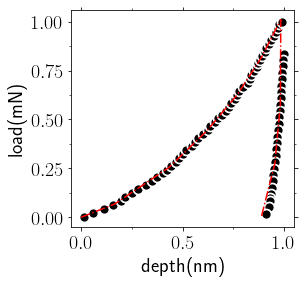

<AxesSubplot:xlabel='depth(nm)', ylabel='load(mN)'>

In [5]:
symbols=utl.Symbols()

finder=Finder(confParser['test data files']['load_depth_path'])
display(finder.Get(0))

#--- parse load curve
test_data = TestData(path_ld='%s/%s'%(confParser['test data files']['load_depth_path'],finder.Get(0)),
                     path_gb=confParser['test data files']['test_data_file_path'],
                    )

test_data.Parse()
test_data.Scale()
ax=utl.PltErr(test_data.data[:,0],test_data.data[:,1],
#                xlim=(0,20),ylim=(0,0.2),
               attrs=symbols.GetAttrs(count=0,fmt='.',nevery=2),
              Plot=False,
               )
test_data.Interp(bins=np.arange(test_data.data[:,0].min(),test_data.data.max(),0.1))
utl.PltErr(test_data.edges,test_data.xsum,
#                xlim=(0,20),ylim=(0,0.2),
               attrs={'fmt':'-.r'},
                ax=ax,
               xstr='depth(nm)',
               ystr='load(mN)',
#               attrs=symbols.GetAttrs(fmt='-.r'),
               title='png/loadDepth.png'
            
                )

### multiple grains

open and load data from test_data.csv complete.


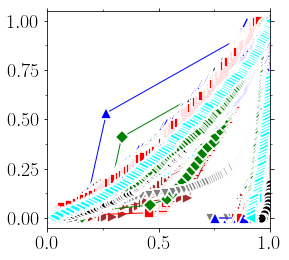

In [6]:
test_data_file_path = confParser['test data files']['test_data_file_path']
test_data_file_path2nd = confParser['test data files']['test_data_file_path2nd']
test_data_grains, test_data_grains2nd = load_test_data(test_data_file_path, 
                                         test_data_file_path2nd
                                        )
ngrains = test_data_grains.shape[0]

ax  = utl.PltErr(None,None,Plot=False)

#--- prescribed range for displacements 
(xlo,xhi,dx)=(0.0,1.0,0.01)

#--- loop over indented grains
TestData.ld_curve = {}
TestData.load = {}
for fp,count in zip(finder.files,range(len(finder.files))): 
    test_data = TestData(path_ld='%s/%s'%(confParser['test data files']['load_depth_path'],fp),
                     path_gb=confParser['test data files']['test_data_file_path'],
                     verbose=False,
                    )
    test_data.Parse()
    test_data.Scale()
#    if not test_data.is_included(xlo,xhi): #--- ld curve includes this range
#        continue
    test_data.Interp(bins=np.arange(xlo,xhi,dx)) #--- interpolate
    try:
        GrainIndex = test_data.GetGrainIndex()
    except:
        continue
    #--- plot
    utl.PltErr(test_data.data[:,0],test_data.data[:,1],
                attrs=symbols.GetAttrs(count=count%7),
               ax=ax,Plot=False,
               xlim=(0,xhi),# ylim=(0,6),
              
              )
    TestData.Append(GrainIndex,test_data.edges,test_data.xsum) #--- assemble feature matrix: append displacements
    
#--- predictors are the displacements
predictors = TestData.BuildFeature(TestData.ld_curve, 
                                   ngrains,
                                   np.arange(xlo,xhi,dx).shape[0]
                                  )

#---- forces
forces = TestData.BuildFeature(TestData.load, 
                                   ngrains,
                                   np.arange(xlo,xhi,dx).shape[0]
                                  )


### missing data

In [7]:
class AddMissing:
    '''
    interpolate using k-nearest neighbors
    '''
    def __init__(self,cords,val,query_index,verbose=False):

        self.query_index = query_index.flatten()
        self.points    = cords
        self.val = val.copy()
        self.verbose = verbose

    def kdTree(self,k):
        tree = KDTree( self.points )
        dd, ii = tree.query([self.points], k=k)
        self.neigh_mat= ii[0] #--- nearest neighbor matrix
        if self.verbose:
            print('neigh_mat.shape:',self.neigh_mat.shape)
        
    def interpolate(self):
        #--- nearest neighbor values
        h_mat = np.c_[list(map(lambda x:self.val[x],self.neigh_mat))]
        if self.verbose:
            print('h_mat.shape:',h_mat.shape)
        assert np.all(list(map(lambda x:np.any(~np.isnan(x)),h_mat))), 'increase k!'
        #--- filter query points
        h_list = list(map(lambda x:x[np.all(~np.isnan(x),axis=1)],h_mat[self.query_index]))
        assert len(h_list) == h_mat[self.query_index].shape[0]
        
        #--- average
        h_mean = list(map(lambda x: np.mean(x,axis=0), h_list))
        if self.verbose:
            print('h_mean.shape:',h_mean[0].shape)
        query_rows = np.arange(self.query_index.shape[0])[self.query_index]
        self.val[query_rows] = np.c_[h_mean]

        

# interp0 = AddMissing(np.c_[test_data_grains[['x','y']]],
#                      predictors,#np.c_[df.drop(columns=[0])],
#                      np.all(np.isnan(predictors),axis=1),
#                      verbose=True,
#                            )

# interp0.kdTree(64) #--- nearest neighbors
# interp0.interpolate()
# predictors = interp0.val.shape

## build graph

### train-test split

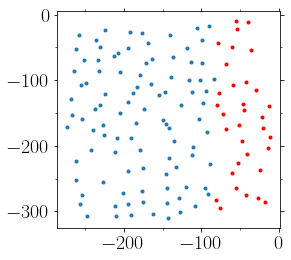

<AxesSubplot:>

In [8]:
mask = np.all(~np.isnan(predictors),axis=1) #--- indented grains
mask_xy = train_test_split(test_data_grains['x'],test_data_grains['y']) #--- subset of grains

#--- train-test split
train_mask = np.all([mask_xy,mask],axis=0)
test_mask = np.all([~mask_xy,mask],axis=0)

#--- plot
ax=utl.PltErr(test_data_grains[train_mask]['x'],test_data_grains[train_mask]['y'],
              attrs={'fmt':'.'},
             Plot=False
             )

utl.PltErr(test_data_grains[test_mask]['x'],test_data_grains[test_mask]['y'],
              attrs={'fmt':'.','color':'red'},
           ax=ax
             )

In [274]:
train_mask

array([False, False,  True, ..., False, False, False])

In [10]:
#--- set parameters
SEED =4441666
np.random.seed(SEED)
tf.set_random_seed(SEED)
#
pure_lab='' 
data_split = None
data_split_lab=''
#


#--- path for csv data files
# test_data_file_path=confParser['test data files']['test_data_file_path']
# test_data_file_path2nd=confParser['test data files']['test_data_file_path2nd']


#--- graph structure  
static_graph_tr, train_mask_np, val_mask_np, test_mask_np,\
target_nodes_np, weight_np = base_graph(test_data_file_path, 
                                        test_data_file_path2nd,
                                        predictors,
                                        train_mask,
                                        test_mask,
                                        logtrans=data_split)
print(static_graph_tr.keys())
for k in static_graph_tr.keys():
    try:
        print(k, static_graph_tr[k].shape)
    except AttributeError:
        print(k)

input_graph = utils_tf.data_dicts_to_graphs_tuple([static_graph_tr])
graphs_tuple = utils_np.data_dicts_to_graphs_tuple([static_graph_tr])
#print(input_graph)



open and load data from test_data.csv complete.
dict_keys(['globals', 'nodes', 'edges', 'receivers', 'senders'])
globals
nodes
edges
receivers
senders


In [16]:
static_graph_tr['nodes']

[[-39.2925, -11.73705, 45.2639, 98.0, 9.0],
 [-55.001, -9.001784, 74.94776, 159.0, 6.0],
 [-89.87787, -17.84557, 52.65392, 114.0, 9.0],
 [-224.7325, -22.96657, 102.5366, 222.0, 12.0],
 [-105.0307, -20.04308, 60.9677, 132.0, 4.0],
 [-54.32268, -22.01188, 109.0029, 254.0, 19.0],
 [-192.0816, -26.80881, 79.44276, 172.0, 12.0],
 [-176.5177, -28.46244, 87.75654, 190.0, 13.0],
 [-257.1728, -30.8979, 84.98528, 184.0, 8.0],
 [-98.97113, -38.66311, 40.64513, 88.0, 5.0],
 [-169.2267, -43.78811, 47.1114, 102.0, 6.0],
 [-139.9645, -30.72248, 283.5922, 703.0, 27.0],
 [-235.7862, -38.62065, 190.2931, 412.0, 16.0],
 [-260.9201, -52.5561, 29.5601, 64.0, 4.0],
 [-60.32267, -49.56742, 58.19644, 126.0, 5.0],
 [-118.6551, -51.1109, 77.59525, 168.0, 11.0],
 [-230.0646, -49.62089, 136.7154, 296.0, 10.0],
 [-78.93143, -42.72137, 216.1582, 554.0, 46.0],
 [-136.8735, -64.4451, 97.91782, 219.0, 10.0],
 [-206.9713, -58.40684, 102.5366, 222.0, 4.0],
 [-193.9993, -51.1388, 199.5307, 432.0, 17.0],
 [-213.0498, -62.

In [19]:
import json
with open('graph.json','w') as fp:
    json.dump(static_graph_tr,fp)

In [22]:
json.load(open('graph.json')).keys()

dict_keys(['globals', 'nodes', 'edges', 'receivers', 'senders'])

## plot h map

In [18]:
class interpolate:
    '''
    interpolate using k-nearest neighbors
    '''
    def __init__(self,cords,val,query_points):

        self.points    = cords
        self.query_points = query_points
        self.val = val.copy()

    def kdTree(self):
        tree = KDTree( self.points )
        dd, ii = tree.query([self.query_points], k=1)
        self.neigh_mat= ii[0] #--- nearest neighbor matrix
        
        
    def interpolate(self):        
        return self.val[self.neigh_mat.flatten()]

#--- discrete set of points
points=np.c_[static_graph_tr['nodes']][:,0:2]
    
#--- plot hardness map
[xlo,xhi]=[points[:,0].min(),points[:,0].max()]
[ylo,yhi]=[points[:,1].min(),points[:,1].max()]
dx=dy=0.5
xlin = np.arange(xlo,xhi,dx)
ylin = np.arange(ylo,yhi,dy)
xv,yv=np.meshgrid(xlin,ylin)
query_points = list(zip(xv.flatten(),yv.flatten()))

#--- interpolate
interp = interpolate(points,
                     np.array(target_nodes_np),
                     np.c_[query_points],
                           )
interp.kdTree()
vi = interp.interpolate()
vi = vi.reshape((xv.shape))

#--- imshow
n=vi.T.shape[1]
val=np.array([vi.T[:,(n-1)-j] for j in range(n)])
val.shape
utl.PltBitmap( val.T,
               xlabel = '$y$', ylabel = '$x$',
               xlim = (yhi,ylo), ylim = (xlo,xhi),
               frac = 1.0, #--- plot a patch
               zscore = False,
               title = 'cxy.png',
               colorbar=True,
              origin='lower'
#               **kwargs
              )

ValueError: cannot reshape array of size 35733000 into shape (645,554)

## Visualize 
### euclidean space

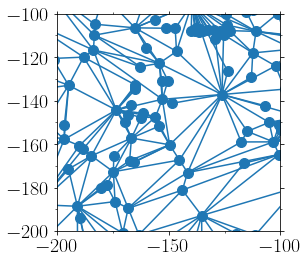

<AxesSubplot:>

In [277]:
ax=utl.PltErr(np.c_[static_graph_tr['nodes']][:,0],
         np.c_[static_graph_tr['nodes']][:,1],
         fmt='.',
        markersize=10,
               Plot=False,
        )
for i,j in zip(static_graph_tr['senders'],static_graph_tr['receivers']):
    x=[static_graph_tr['nodes'][i][0],static_graph_tr['nodes'][j][0]]
    y=[static_graph_tr['nodes'][i][1],static_graph_tr['nodes'][j][1]]
    utl.PltErr(x,y,
               attrs={'fmt':'-','color':'C0'},
               ax=ax,
                  Plot=False,
              )
    

utl.PltErr(None,None,ax=ax,
            xlim=(-200,-100),
            ylim=(-200,-100),
            title='png/graph.png'
          )

### nodes and edges

In [181]:
def get_cmap(n):
    colors = [(1,1,1)] + [(np.random.random(),np.random.random(),np.random.random()) for i in range(n-1)]
    new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=n)
    return new_map

new_map = get_cmap(test_data_grains.shape[0])

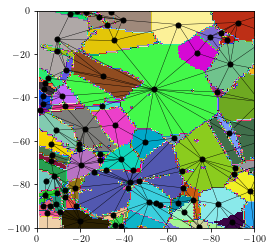

In [182]:
#--- plott grains
id_matrix = np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path'],
          )
n=id_matrix.T.shape[1]
val=np.array([id_matrix.T[:,(n-1)-j] for j in range(n)])
points=np.c_[test_data_grains[['x','y']]]
[xlo,xhi]=[points[:,0].min(),points[:,0].max()]
[ylo,yhi]=[points[:,1].min(),points[:,1].max()]
plt.imshow(val.T,
#            id_matrix,
            origin='lower',
            extent = (yhi,ylo,xlo,xhi),
#               extent = (0,-100,-100,0),
            cmap=new_map
          )


#--- plot centers
pixel_cutoff=1
filtr = test_data_grains['grainSize']>pixel_cutoff
points=np.c_[test_data_grains[filtr][['x','y']]]
xt=points[:,0] 
yt=points[:,1]
plt.plot(yt,
         xt,
         '.',color='black',
         markersize=10,
        )

#--- plot edges
singlePixel = test_data_grains[test_data_grains['grainSize']<=pixel_cutoff].index
for i,j in zip(static_graph_tr['senders'],static_graph_tr['receivers']):
    if i in singlePixel or j in singlePixel:
        continue
    x=[static_graph_tr['nodes'][i][0],static_graph_tr['nodes'][j][0]]
    y=[static_graph_tr['nodes'][i][1],static_graph_tr['nodes'][j][1]]
    plt.plot(y,x,
               '-',color='black',
             markersize=12,
             lw=.4,
              )

#--- range
plt.xlim(0,-100)
plt.ylim(-100,0)
plt.savefig('png/gnn.png',bbox_inches='tight',pad_inches=0.0,dpi=300)

### plot indented grains

In [206]:
mask = np.all(np.isnan(predictors),axis=1)
grainID_notindented = np.c_[test_data_grains[mask]['#grainID']].astype(int)

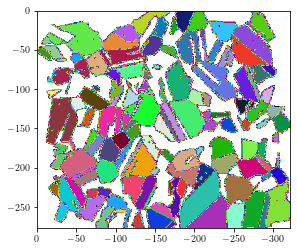

In [209]:
id_matrix = np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path'],
          )
n=id_matrix.T.shape[1]
val=np.array([id_matrix.T[:,(n-1)-j] for j in range(n)])
points=np.c_[test_data_grains[['x','y']]]
[xlo,xhi]=[points[:,0].min(),points[:,0].max()]
[ylo,yhi]=[points[:,1].min(),points[:,1].max()]

for grain_id in grainID_notindented.flatten():
    val[val == grain_id]=0
plt.imshow(val.T,
#            id_matrix,
            origin='lower',
            extent = (yhi,ylo,xlo,xhi),
#               extent = (0,-100,-100,0),
            cmap=new_map,
          )
plt.savefig('png/indented.png',bbox_inches='tight',pad_inches=0.0,dpi=300)

# Train

In [254]:
num_processing_steps_tr = 3
#--- Data / training parameters.
num_training_iterations = 8000 #000#0 #20000
learning_rate = 1e-2/4 #7.5e-6

train_mask = tf.constant(train_mask_np, dtype=tf.bool)
test_mask  = tf.constant(test_mask_np , dtype=tf.bool)
val_mask   = tf.constant(val_mask_np  , dtype=tf.bool)

target_nodes = tf.constant(target_nodes_np)
weight = tf.constant(weight_np)
weight = None ##NOTE comment out if weights wanted 


# Create the model.
node_output_size = len(target_nodes_np[0])
model = EncodeProcessDecode(node_output_size=node_output_size)
#print(model.summary())

#--- training base graph
output_ops, latent_ops = model(input_graph, num_processing_steps_tr) #[-1]
# Training loss.
loss_op_tr = []
loss_op_va = []
loss_op_ts = []
corr_op_tr = []
corr_op_va = []
corr_op_ts = []

for op in output_ops:
    loss_op_tr.append( create_loss_ops(target_nodes, op, train_mask,weight))
    loss_op_va.append( create_loss_ops(target_nodes, op,   val_mask,weight))
    loss_op_ts.append( create_loss_ops(target_nodes, op,  test_mask,weight))
    corr_op_tr.append( create_corr_ops(target_nodes, op, train_mask))
    corr_op_va.append( create_corr_ops(target_nodes, op,   val_mask))
    corr_op_ts.append( create_corr_ops(target_nodes, op,  test_mask))

# Training loss across processing steps.
loss_op_tr_sum = sum(loss_op_tr) / num_processing_steps_tr


# Optimizer.
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr_sum)


training_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
correlat_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
counter = 0


# This cell resets the Tensorflow session, but keeps the same computational
# graph.
sess = tf.Session()
sess.run(tf.global_variables_initializer())

print(snt.format_variables(model.variables))

best_corr = np.zeros((num_processing_steps_tr,3))
best_val_loss = np.inf
best_corr_loss = 0.0
best_val_loss_all = np.inf*np.ones(num_processing_steps_tr)
best_corr_loss_all = np.zeros(num_processing_steps_tr)
last_improved = 0
early_stopping_crit = num_training_iterations #1000


measure_val_by_loss= True
print("MEASURE VALIDATION BY LOSS ", measure_val_by_loss)

# #--- training loop
for iteration in range(num_training_iterations):
    last_iteration = iteration
    train_values = sess.run({
        "step": step_op,
        "loss": loss_op_tr,
        "outputs": output_ops,
        "latents": latent_ops,
        "corr": corr_op_tr

    })
    

    test_values = sess.run({
        "loss_val":  loss_op_va,
        "loss_test": loss_op_ts,
            "corr_val": corr_op_va,
            "corr_test": corr_op_ts
    })
    training_history[counter, 0:num_processing_steps_tr] = train_values['loss']
    training_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = test_values['loss_val']
    training_history[counter, 2*num_processing_steps_tr:] = test_values['loss_test']

    correlat_history[counter, 0:num_processing_steps_tr] = np.median(train_values['corr'])
    correlat_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = np.median(test_values['corr_val'])
    correlat_history[counter, 2*num_processing_steps_tr:] = np.median(test_values['corr_test'])



    if (iteration+1) %100==0:
        print("# {:05d}, training {:.4f}, validation {:.4f}, test {:.4f}".format(iteration+1,training_history[counter,num_processing_steps_tr-1], training_history[counter,2*num_processing_steps_tr-1],training_history[counter,-1]  ))

        for i in range(num_processing_steps_tr):
            if measure_val_by_loss:
                cond =  (training_history[counter,num_processing_steps_tr+i] < best_val_loss_all[i])
                cond_best = (training_history[counter,num_processing_steps_tr+i] < best_val_loss)
            else:
                cond =  (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss_all[i])
                cond_best = (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss)
            if cond:
                step_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
#                 pdb.set_trace()
                best_corr[i,0] = stats.pearsonr( step_output[train_mask_np].flatten(),  np.array(target_nodes_np)[train_mask_np].flatten() )[0]
                best_corr[i,1] = stats.pearsonr( step_output[val_mask_np].flatten(),   np.array(target_nodes_np)[val_mask_np].flatten() )[0]
                best_corr[i,2] = stats.pearsonr( step_output[test_mask_np].flatten(),   np.array(target_nodes_np)[test_mask_np].flatten() )[0]
                #print("      best val res, r: training {:.4f}, validation {:.4f}, test {:.4f}".format( best_corr[0], best_corr[1], best_corr[2]  ))
                best_val_loss_all[i] = training_history[counter,num_processing_steps_tr+i]
                best_corr_loss_all[i] = correlat_history[counter,num_processing_steps_tr+i]
                if cond_best:
                    best_output = np.copy(step_output)
                    best_latent = sess.run(latent_ops[i])
                    #print(best_latent.shape)
                    best_val_loss = training_history[counter,num_processing_steps_tr+i]
                    best_corr_loss = correlat_history[counter,num_processing_steps_tr+i]
                    last_improved = counter
    counter+=1 
    if counter > last_improved + early_stopping_crit:
        print('NO IMPROVEMENT IN {} STEPS, STOPPING TRAINING...'.format(int(early_stopping_crit)))
        break


f_label = "{}_{}_{}{}".format(pure_lab, learning_rate,num_processing_steps_tr,data_split_lab)

training_history = training_history[:counter]
correlat_history = correlat_history[:counter]
for i in range(num_processing_steps_tr):
    print("    {} steps:  best val res, r: training {:.4f}, validation {:.4f}, test {:.4f}".format(i+1, best_corr[i,0], best_corr[i,1], best_corr[i,2]  ))
    latest_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
#     np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_latest_pred_{}_{}.dat".format(f_label,i+1), latest_output)



# np.savetxt(   "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_training_history_{}.dat".format(f_label), training_history)
# np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_correlation_history_{}.dat".format(f_label), correlat_history)
# np.savetxt(          "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_pred_{}.dat".format(f_label), best_output)
# np.save(           "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_latent_{}.npy".format(f_label), best_latent)


Variable                                                               Shape  Type     Collections                            Device
EncodeProcessDecode_2/graph_independent/node_model/node_output/b       100    float32  global_variables, trainable_variables  (legacy)
EncodeProcessDecode_2/graph_independent/node_model/node_output/w       8x100  float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_4/graph_independent/edge_model/layer_norm/beta     8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_4/graph_independent/edge_model/layer_norm/gamma    8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_4/graph_independent/edge_model/mlp/linear_0/b      8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_4/graph_independent/edge_model/mlp/linear_0/w      1x8    float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_4/graph_independent/edge_model/mlp/li

# 01000, training 0.0078, validation 0.0035, test 0.0035
# 01100, training 0.0078, validation 0.0034, test 0.0034
# 01200, training 0.0078, validation 0.0034, test 0.0034
# 01300, training 0.0078, validation 0.0035, test 0.0035
# 01400, training 0.0078, validation 0.0035, test 0.0035
# 01500, training 0.0079, validation 0.0035, test 0.0035
# 01600, training 0.0078, validation 0.0035, test 0.0035
# 01700, training 0.0078, validation 0.0035, test 0.0035
# 01800, training 0.0078, validation 0.0035, test 0.0035
# 01900, training 0.0078, validation 0.0035, test 0.0035
# 02000, training 0.0078, validation 0.0035, test 0.0035
# 02100, training 0.0078, validation 0.0034, test 0.0034
# 02200, training 0.0078, validation 0.0034, test 0.0034
# 02300, training 0.0078, validation 0.0035, test 0.0035
# 02400, training 0.0078, validation 0.0035, test 0.0035
# 02500, training 0.0078, validation 0.0035, test 0.0035
# 02600, training 0.0078, validation 0.0034, test 0.0034
# 02700, training 0.0078, valid

## mse

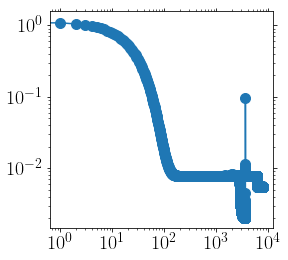

<AxesSubplot:>

In [255]:
utl.PltErr(range(training_history.shape[0]),
           training_history[:,num_processing_steps_tr-1],
           xscale='log',
           yscale='log',
          )

In [291]:
# i=1
# tep_output =  sess.run(output_ops[i].nodes)
# best_output = np.copy(step_output)

In [292]:
# with sess.as_default():
#     print(output_ops[0].receivers.eval().shape)

## predictions

In [293]:
# !mkdir png
# #ax=utl.PltErr(target_nodes_np,target_nodes_np,attrs={'fmt':'-r'},Plot=False)
# filtr = [train_mask_np,test_mask_np][1]
# xmin=np.min([target_nodes_np,best_output])
# xmax=np.max([target_nodes_np,best_output])
# utl.PltErr(np.array(target_nodes_np)[filtr], np.array(best_output)[filtr],
#            attrs={'fmt':'.'},
#             xlim=(xmin,xmax),
#            ylim=(xmin,xmax),
#            title = 'png/hardness.png',
#            xstr='actual',
#            ystr='predicted',
# #           ax=ax,
#           )

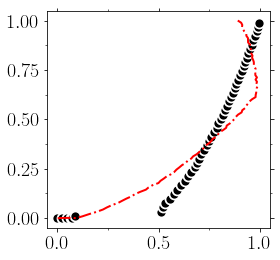

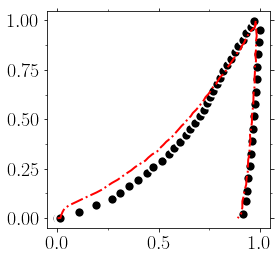

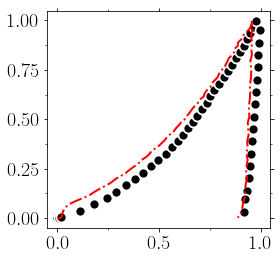

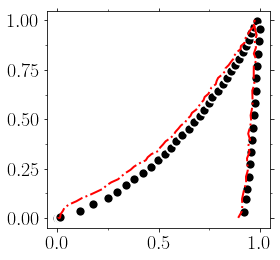

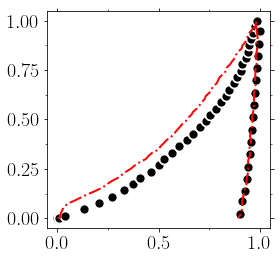

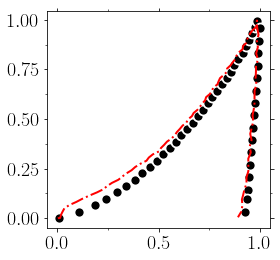

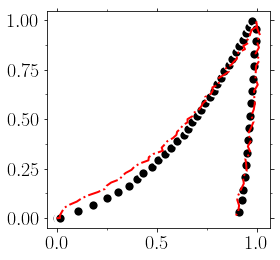

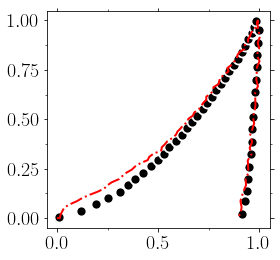

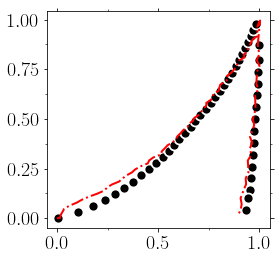

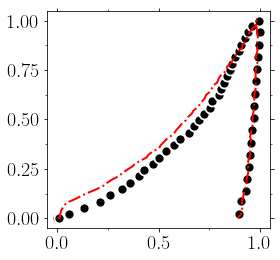

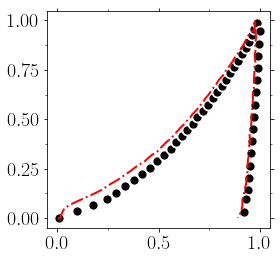

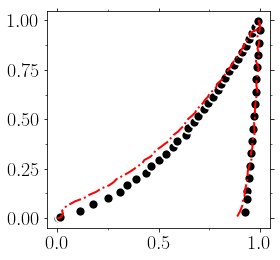

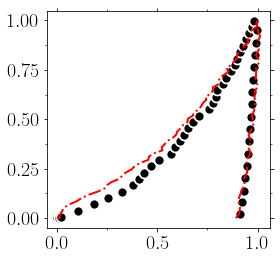

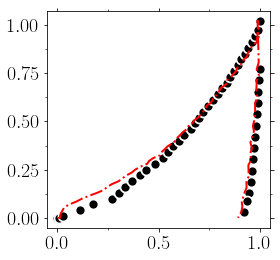

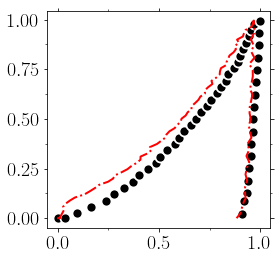

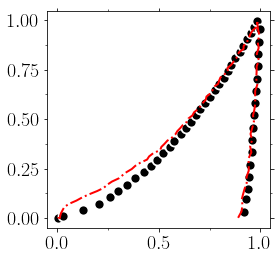

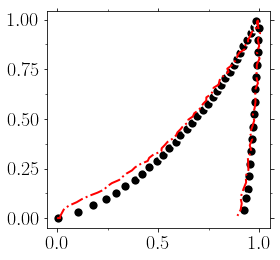

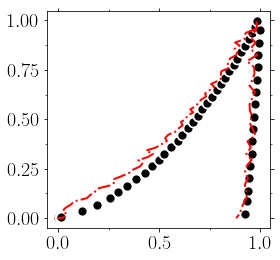

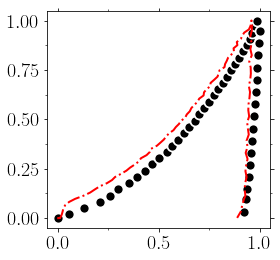

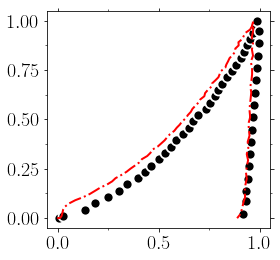

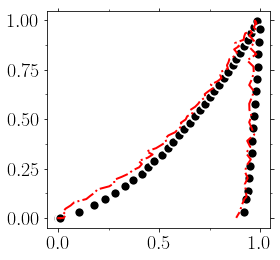

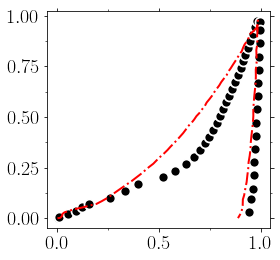

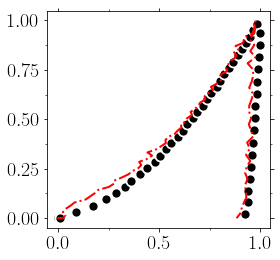

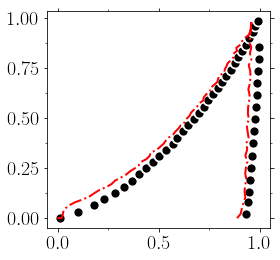

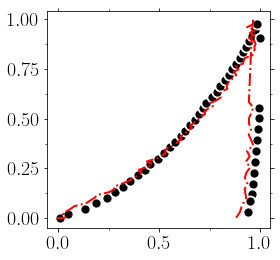

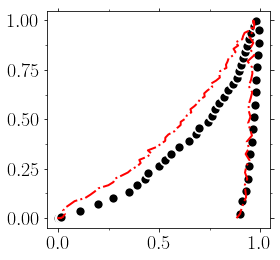

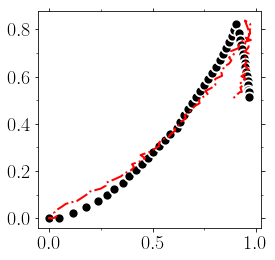

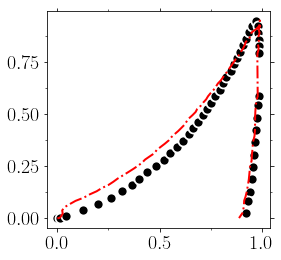

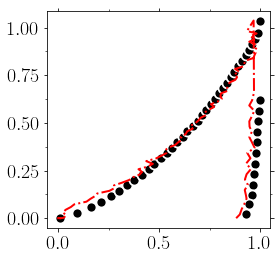

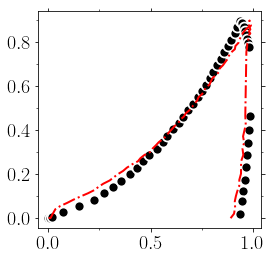

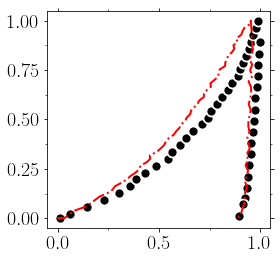

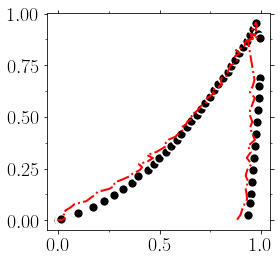

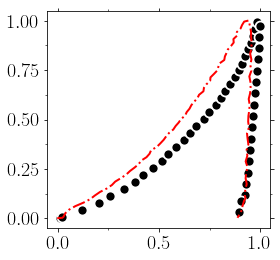

In [270]:
# grain_indx=5
# if train_mask_np[grain_indx]:
#     print('training set')
# else:
#     print('test set')

for grain_indx in range(len(target_nodes_np)):
    if not test_mask_np[grain_indx]:
        continue
    ax=utl.PltErr(None,None,Plot=False)
    utl.PltErr(
#                range(len(target_nodes_np[grain_indx])),
               target_nodes_np[grain_indx], 
               forces[grain_indx],
               attrs=symbols.GetAttrs(count=0,fmt='.',nevery=2),
                Plot=False,
               ax=ax
                 )

    utl.PltErr(
               best_output[grain_indx],
                       forces[grain_indx],

               attrs={'fmt':'-.','lw':2,'color':'red'},
    #            xlim=(xmin,xmax),
    #           ylim=(xmin,xmax),
    #           title = 'png/hardness.png',
#                xstr='disp',
#                ystr='load',
               ax=ax,
                               Plot=False,
#                 xlim=(0,125),
#                 ylim=(0,1.3),

              )
    
    utl.PltErr(None,None,
               ax=ax,
               title='png/prediction%s.png'%grain_indx,
              dpi=55,
              )


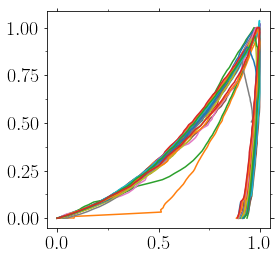

In [257]:
ax=utl.PltErr(None,None,Plot=False)
for grain_indx in range(len(target_nodes_np)):
    if not test_mask_np[grain_indx]:
        continue

    utl.PltErr(
               target_nodes_np[grain_indx], 
                forces[grain_indx],
#               best_output[grain_indx],
               attrs={'fmt':'-'},
    #            xlim=(xmin,xmax),
    #           ylim=(xmin,xmax),
    #           title = 'png/hardness.png',
#                xstr='disp',
#                ystr='load',
               ax=ax,
                               Plot=False,

              )

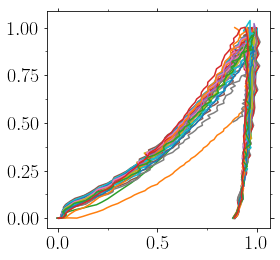

In [258]:
ax=utl.PltErr(None,None,Plot=False)
for grain_indx in range(len(target_nodes_np)):
    if not test_mask_np[grain_indx]:
        continue

    utl.PltErr(
               best_output[grain_indx],
                        forces[grain_indx],

               attrs={'fmt':'-'},
    #            xlim=(xmin,xmax),
    #           ylim=(xmin,xmax),
    #           title = 'png/hardness.png',
#                xstr='disp',
#                ystr='load',
               ax=ax,
                               Plot=False,

              )

<AxesSubplot:>

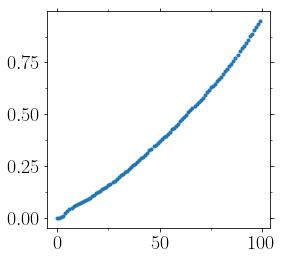

In [48]:
grain_indx=1080
utl.PltErr(range(len(target_nodes_np[grain_indx])),
           target_nodes_np[grain_indx], 
           attrs={'fmt':'.'},
            Plot=False
             )